In [18]:
!pip install supervision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [20]:
from torch.cuda import device

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import supervision as sv
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint="/content/sam_vit_h_4b8939.pth").to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)


image_bgr = cv2.imread('/content/frame_saved.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)
masks = mask_generator.generate(image_rgb)
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n63v_c1h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n63v_c1h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


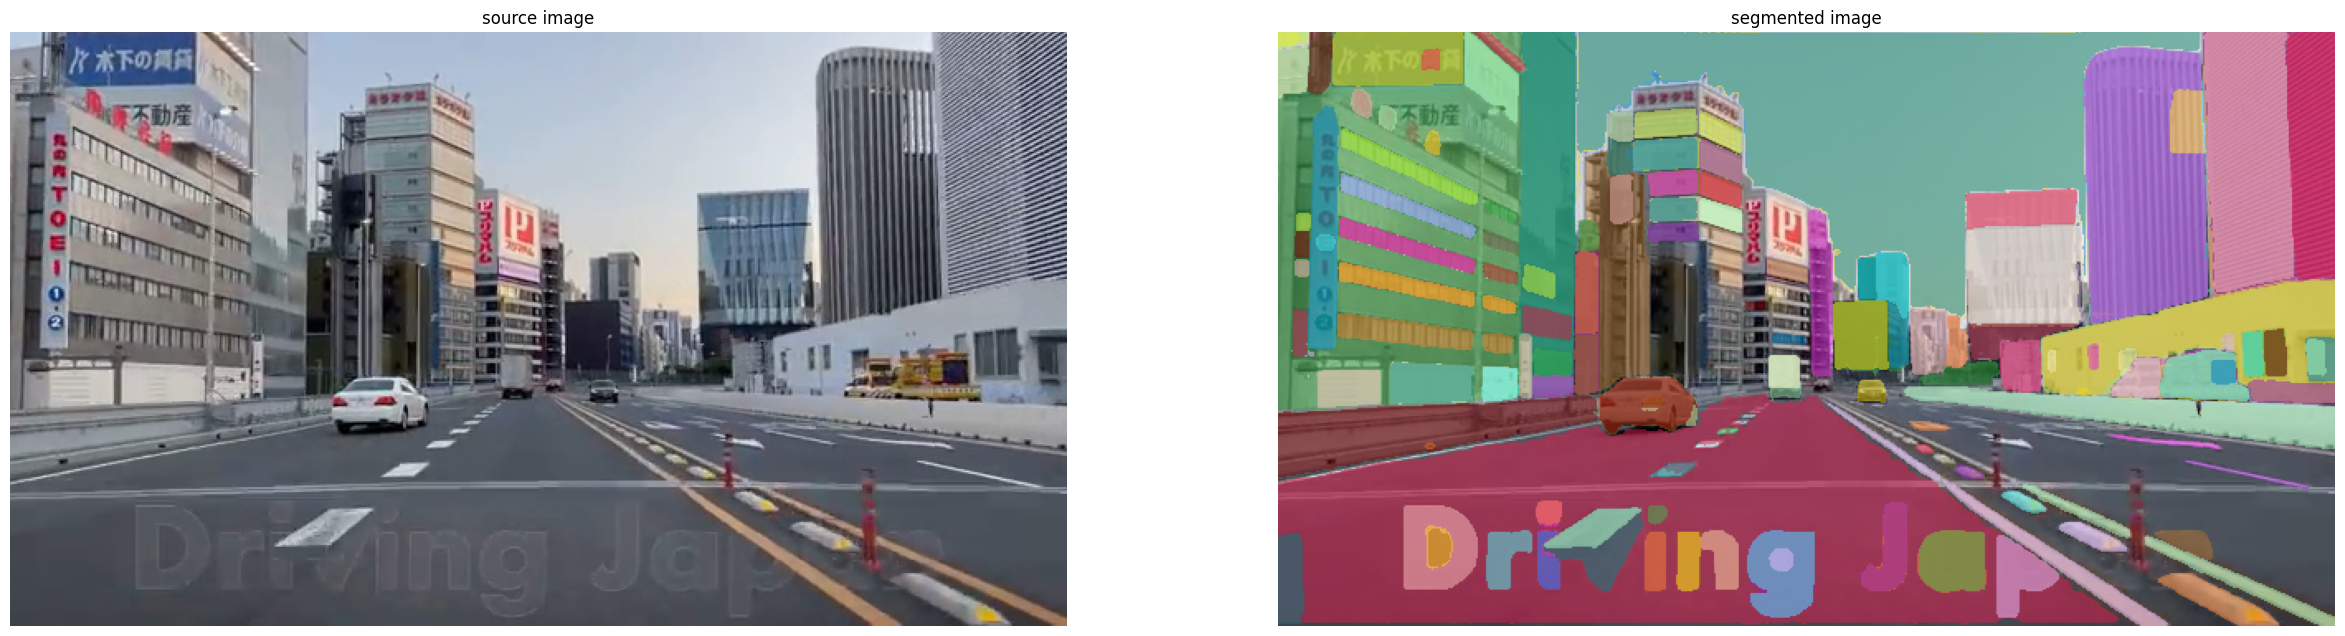

In [21]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'],
    size=(30, 30)
)

In [22]:
len(masks)

149

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [30]:
from segment_anything import SamPredictor
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)
input_point = np.array([[230, 250]])
input_label = np.array([1])


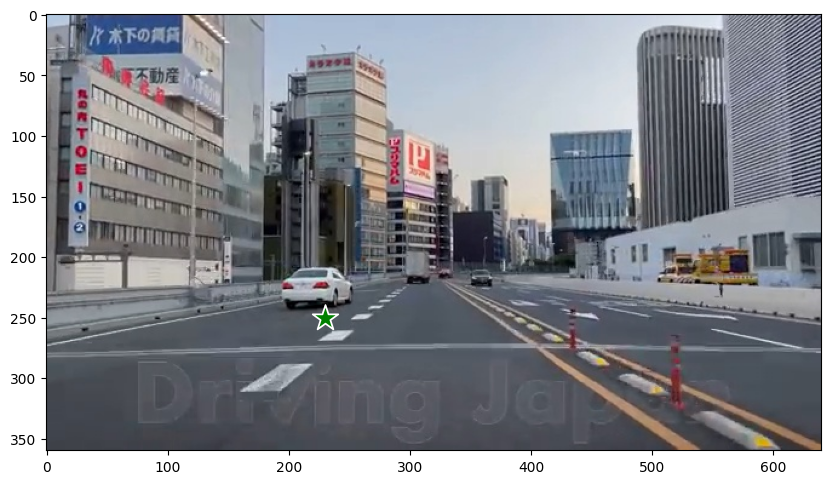

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [32]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [28]:
masks.shape 

(3, 360, 640)

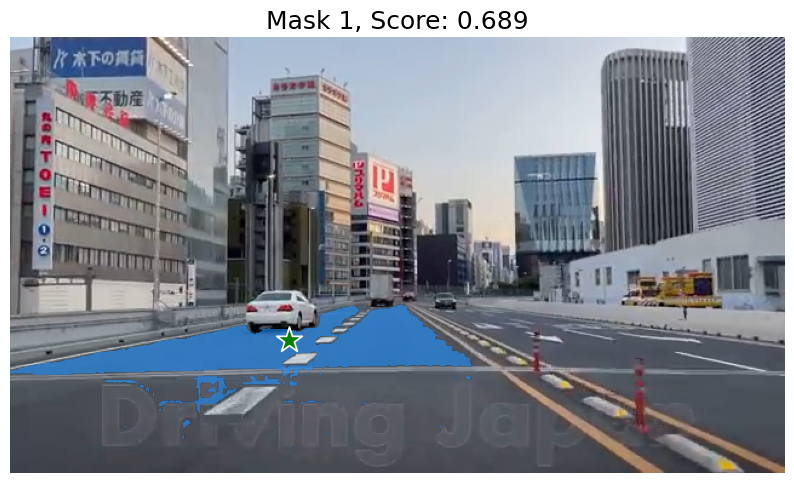

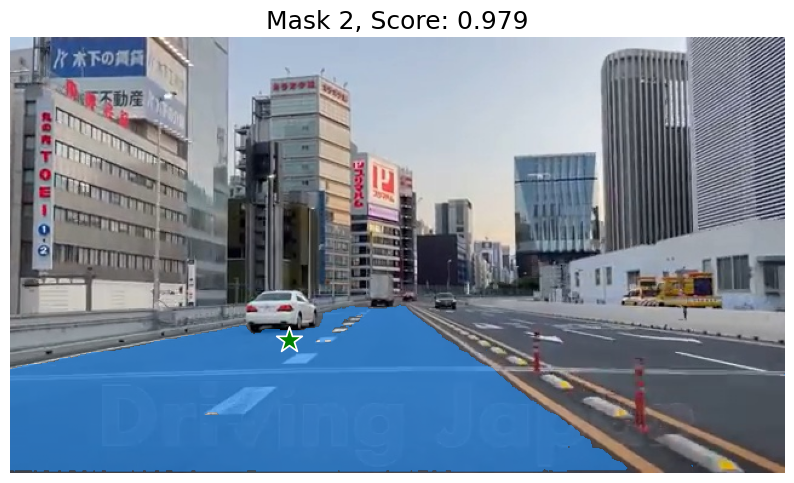

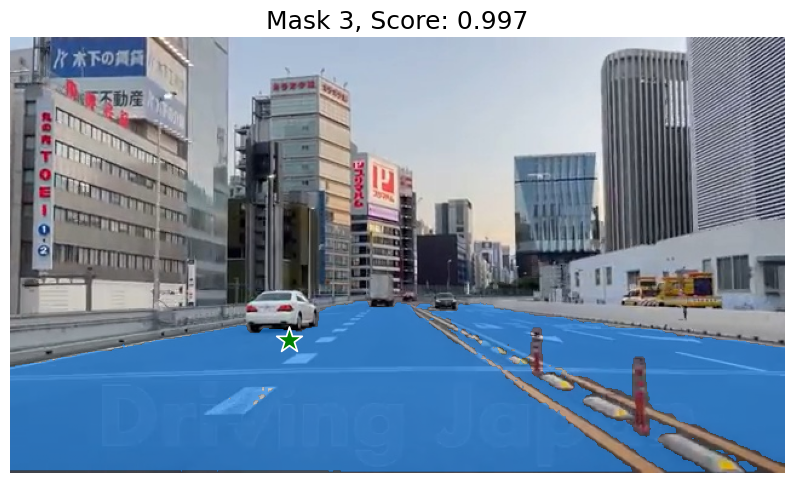

In [33]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image_rgb)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [34]:
input_point = np.array([[230, 250], [600, 250]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :] 

In [35]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

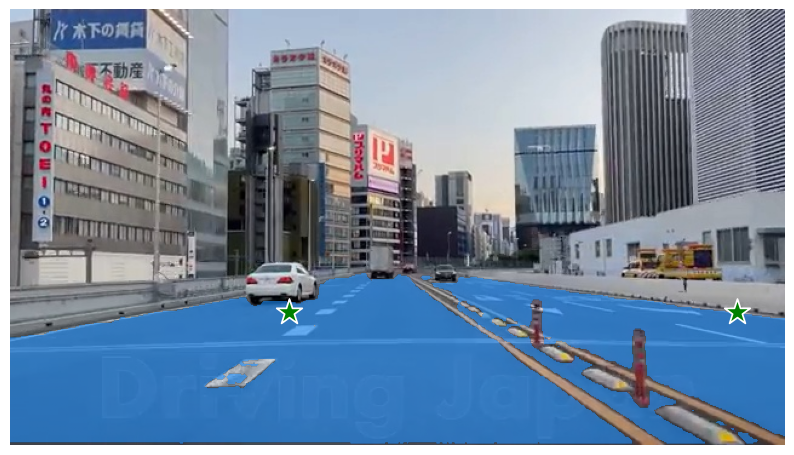

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [38]:
input_box = np.array([180, 200, 250, 250])

In [39]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

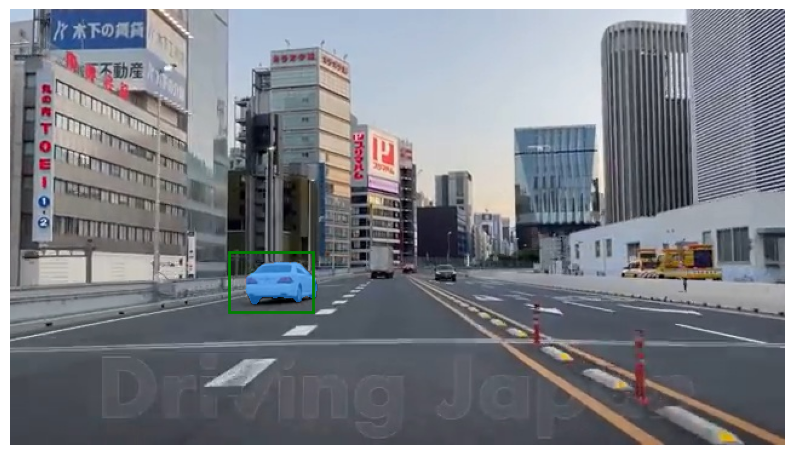

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()